In [1]:
#
# This notebook is written in a way intended to be view
# with cell inputs hidden. If this comment is visible,
# the data is at the end of the report, you may just ignore
# all the code.
#
# intended usage: convert to html with cell execution enabled
# > jupyter nbconvert --to=html --no-input --ExecutePreprocessor.enabled=True TM-status-report.ipynb
#
# if working in the gis repository, run:
# > make
# to automatically run, convert, and publish of github pages


# Tasking Manager COVID-19 Projects Summary


This is a Jupyter notebook for quickly summarizing the status of a HOTOSM Tasking Manager campaing using the TM API.
Data show here is periodically updated by and automated bot.


In [8]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.core.display import display, HTML
# make sure pandas doesn't truncate the dataframe when rendered
pd.set_option('display.max_rows', 500)

import tasking_manager_client as tm

            
# set the text search keyword
textSearch = 'covid'
projectStatuses = 'ARCHIVED'
instance = 'tasks.hotosm.org'

# for notebooks used for reporting, it's nice to
# timestamp of the data, since it can get old quickly
now = datetime.utcnow()
print(f'data last updated: {now} UTC')
print(f'tasking manager:   {instance}')
print(f'search keyword:    {textSearch}')

data last updated: 2020-05-02 11:49:18.582433 UTC
tasking manager:   tasks.hotosm.org
search keyword:    covid


In [3]:

# concatenate paginated API results into one dataframe
result = pd.concat(tm.v1.project_search(textSearch=textSearch, projectStatuses=projectStatuses), ignore_index=True);
# search API pagination sometimes returns the same project more than once
result = result.drop_duplicates(subset='projectId');


In [4]:
def get_summaries():
  for idx, project in result.iterrows():


    endpoint = f'/api/v1/project/{project.projectId}/summary'
    r = requests.get('https://' + tm.DEFAULT_INSTANCE + endpoint)
    df = pd.json_normalize(r.json())
    yield df

summaries = pd.concat(get_summaries())
# summaries

In [5]:
cols_to_use = summaries.columns.difference(result.columns)
result = result.merge(summaries, suffixes=('', '_duplicate'), how='outer')
result.drop(result.filter(regex='_duplicate$').columns.tolist(),axis=1, inplace=True)
result.columns

Index(['projectId', 'locale', 'name', 'shortDescription', 'mapperLevel',
       'priority', 'organisationTag', 'campaignTag', 'percentMapped',
       'percentValidated', 'status', 'activeMappers', 'page',
       'projectArea(in sq.km)', 'createdBy', 'created', 'due_date',
       'lastUpdated', 'projectPriority', 'entitiesToMap', 'changesetComment',
       'percentBadImagery', 'mapperLevelEnforced', 'validatorLevelEnforced',
       'aoiCentroid.type', 'aoiCentroid.coordinates'],
      dtype='object')

## Current Published and Archived Projects

Published projects: 82
Archived projects:  16
Total projects:     98


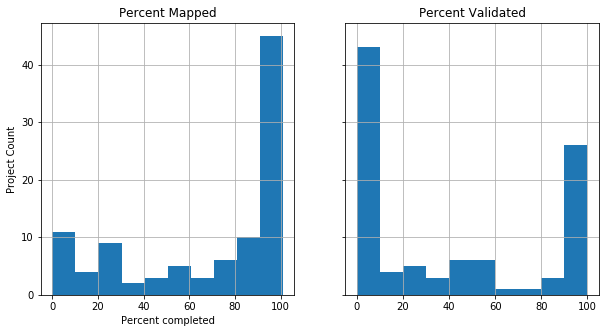

In [6]:

# Total count of projects
print('Published projects:', len(result[result.status == 'PUBLISHED']))
print('Archived projects: ', len(result[result.status == 'ARCHIVED']))
print('Total projects:    ', len(result))

fig, axs = plt.subplots(1,2, sharey=True, figsize=(10,5))
ax = axs[0]
ax.set_ylabel('Project Count')
ax.set_xlabel('Percent completed')
ax.hist(result.percentMapped)
ax.set_title('Percent Mapped')
ax.grid()
ax = axs[1]
ax.grid()
ax.set_title('Percent Validated')
ax.hist(result.percentValidated)
plt.show()



The table below shows the current status of all published and archived projects that include the `covid` keyword.

Projects are sorted by project id, meaning they are in somewhat choronological order.

You can click the project Id to open it in TM.

In [51]:
# We select only the most interesting fields from the dataframe

result['age(days)'] = result['created']
relevant = result[['projectId','name','percentMapped', 'percentValidated','priority','status','age(days)','projectArea(in sq.km)', 'createdBy','organisationTag', 'campaignTag',]]

# age = now - pd.to_datetime(result['created'])

sorted_vals = relevant.sort_values('projectId')
sorted_vals['hyperlink'] = sorted_vals['projectId'].apply(tm.style.format_project_link)
sorted_vals.to_csv('TM-status-report.csv', index=False)
del sorted_vals['hyperlink']

# apply custom styler functions to final table
styled = sorted_vals.style\
    .background_gradient(cmap=tm.style.hotosm_cmap(),subset=['percentMapped', 'percentValidated'])\
    .applymap(tm.style.format_priority, subset=['priority'])\
    .applymap(tm.style.format_status, subset=['status'])\
    .format({'projectId': tm.style.format_clickable_project_id})\
    .format({'projectArea(in sq.km)': np.round})\
    .format({'age(days)': lambda created: (now - pd.to_datetime(created)).days}) 


display(styled)

,projectId,name,percentMapped,percentValidated,priority,status,age(days),projectArea(in sq.km),createdBy,organisationTag,campaignTag
97,813,Mali - [Projets de Cartographie systématique - réseau routier principal vs référence open data],10,0,LOW,ARCHIVED,1966,160305.0,SeverinGeo,OSM Mali,#BaseRoadsVsOpenData
96,5909,"COVID-19, Quehue, Anna, Cusco Peru",98,98,LOW,PUBLISHED,390,149.0,Kateregga1,Gal School Peru,COVID-19
95,7372,"COVID-19 - Paucartambo 1, Cusco, Peru",99,48,LOW,PUBLISHED,159,2660.0,Kateregga1,Gal School Peru,COVID-19
94,7379,"COVID-19 Yaurisque District, Cusco - Peru",100,100,LOW,ARCHIVED,157,101.0,Kateregga1,Gal School Peru,COVID-19
93,7719,"COVID-19 - Chinchero - Urubamba, Peru",99,100,LOW,ARCHIVED,105,102.0,Kateregga1,Gal School Peru,COVID-19
92,7720,"COVID-19 - Yucay, Cusco, Peru",90,90,LOW,ARCHIVED,105,24.0,Kateregga1,Gal School Peru,COVID-19
91,7721,"COVID-19 - Coya - Calca, Peru",98,98,LOW,ARCHIVED,105,70.0,Kateregga1,Gal School Peru,COVID-19
90,7768,"COVID-19 - Chamaca - Chumbivilcas, Peru",96,99,LOW,PUBLISHED,99,674.0,Kateregga1,Gal School Peru,COVID-19
89,7769,"COVID-19 - Saylla - Cusco , Peru",95,100,LOW,ARCHIVED,99,24.0,Kateregga1,Gal School Peru,None
88,7770,"COVID-19 San Jeronimo - Cusco , Peru",94,95,LOW,PUBLISHED,99,96.0,Kateregga1,Gal School Peru,COVID-19


Notebook maintained by @jarmokivekas (GitHub & HOTOSM Slack), feedback and development ideas welcome.